In [ ]:
!pip install -U imbalanced-learn
!pip install spacy

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
import re

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

import string

import spacy
from tqdm.auto import tqdm
import time

In [13]:
data = pd.read_csv("all_reviews_test.csv", sep=";", on_bad_lines="skip")

In [15]:
data.head(10)

,Review,Rating
0,As expected in that it is fine and would suit ...,3
1,Very poor customer service from word for as th...,1
2,There were cockroaches in our room. Rooms were...,1
3,"I got a room with two of my friends, the worst...",1
4,I’ve stayed her numerous times over the years ...,1
5,"We stayed at this hostel for 3 nights, but ple...",1
6,The location of the hostel is great and easy a...,3
7,Stayed her for an event in London with some fr...,2
8,Received the worst customer service in my whol...,1
9,The worst place I ever stayed at! Abercorn Hou...,1


In [16]:
data.tail()

,Review,Rating
135,"Was exactly what we needed, booked very last m...",5
136,When we checked in at 3.00pm the room wasn't r...,1
137,Good location for a first time in London....,3
138,I took a room with my boy and I can say...real...,3
139,Me and my sister stayed at Abercorn House for ...,4


# EDA

## Handling Null Values

In [17]:
data.isna().any()

Review    False
Rating    False
dtype: bool

In [18]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

In [19]:
data.shape

(140, 2)

## Handling Duplicate Values

In [20]:
data.nunique().any()

True

In [21]:
data.nunique()

Review    140
Rating      5
dtype: int64

## Preprocessing the Text

In [23]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 11.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [24]:
# Load the English NLP model
nlp = spacy.load('en_core_web_sm')

# Define stop words
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [25]:
nlp

In [26]:
def preprocess_text(text):
    # Parse the text with Spacy
    doc = nlp(text)
    
    # Lemmatize the tokens and remove stop words
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop]
    
    # Join the lemmas back into a string and return it
    return " ".join(lemmas)

In [27]:
%%time

tqdm.pandas()

data['Review'] = data['Review'].progress_apply(preprocess_text)

  0%|          | 0/140 [00:00<?, ?it/s]

Wall time: 3.95 s


In [28]:
def preprocess_signs(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()

    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()

    return text

In [29]:
data['Review'] = data['Review'].apply(preprocess_signs)

## Commonly Used Words

In [30]:
import matplotlib.pyplot as plt
from collections import Counter
import re

import nltk
from nltk.corpus import stopwords

In [31]:
# Concatenate all tweet texts into a single string
all_text = ' '.join(data['Review'].values)

In [32]:
# Split the text into individual words
words = all_text.split()

In [33]:
# Remove stop words
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]

In [34]:
# Count the frequency of each word
word_counts = Counter(words)

In [35]:
top_words = word_counts.most_common(50)
top_words

[('room', 263),
 ('stay', 118),
 ('clean', 107),
 ('night', 86),
 ('bed', 78),
 ('place', 65),
 ('good', 62),
 ('hostel', 60),
 ('staff', 59),
 ('shower', 52),
 ('london', 52),
 ('kitchen', 44),
 ('walk', 43),
 ('bathroom', 41),
 ('hammersmith', 41),
 ('door', 38),
 ('sleep', 38),
 ('location', 36),
 ('station', 36),
 ('like', 34),
 ('2', 34),
 ('fridge', 33),
 ('close', 33),
 ('time', 32),
 ('find', 31),
 ('people', 30),
 ('book', 30),
 ('need', 30),
 ('hotel', 30),
 ('floor', 29),
 ('share', 29),
 ('cheap', 29),
 ('pay', 28),
 ('toilet', 27),
 ('reception', 27),
 ('minute', 27),
 ('tube', 26),
 ('great', 25),
 ('price', 25),
 ('bad', 25),
 ('nice', 24),
 ('5', 24),
 ('go', 23),
 ('small', 23),
 ('want', 23),
 ('day', 22),
 ('noisy', 22),
 ('single', 21),
 ('area', 21),
 ('hour', 20)]

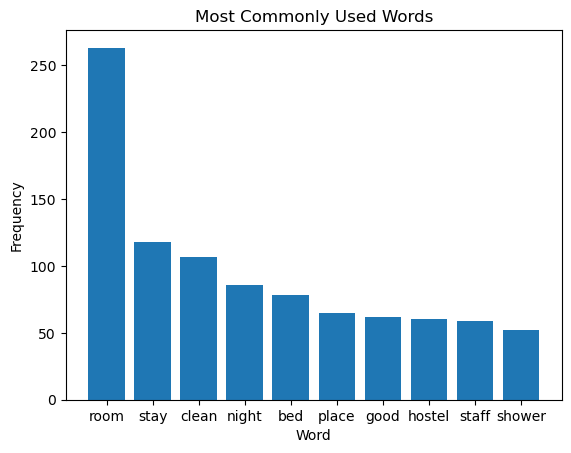

In [36]:
# Create a bar chart of the most common words
top_words = word_counts.most_common(10) # Change the number to show more/less words
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()

## Converting Text into Numerical Features / Vectorization

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['Review'])
y = data['Rating']

## Class Distributions

In [90]:
# Count the number of instances in each class
class_counts = data['Rating'].value_counts()

# Print the class distribution
print('Ratings distribution:')
print(class_counts)

Ratings distribution:
1    44
3    32
4    30
2    21
5    13
Name: Rating, dtype: int64


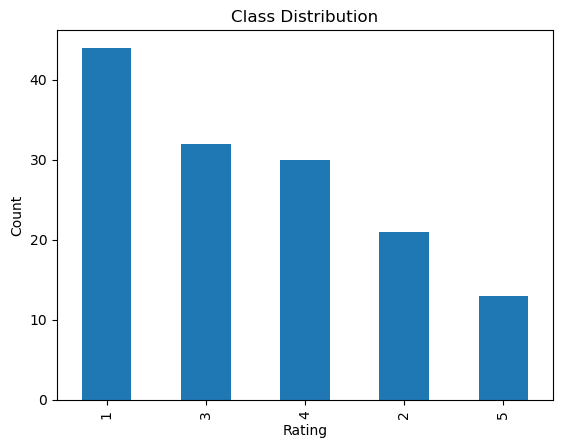

In [39]:
class_counts.plot.bar()
plt.title('Class Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## ML Models

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression Model

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [140]:
import sklearn
print(sklearn.__version__)

1.0.2


In [141]:
# train a Logistic Regression Model
lrm = LogisticRegression()

In [142]:
lrm.fit(X_train, y_train)

LogisticRegression()

In [143]:
# evaluate the classifier on the test set
y_pred = lrm.predict(X_test)

In [144]:
y_pred

array([3, 1, 3, 1, 3, 1, 4, 3, 4, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3,
       4, 1, 4, 1, 1, 1], dtype=int64)

In [145]:
acc_logisticregression = accuracy_score(y_test, y_pred)
f1_logisticregression = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc_logisticregression)
print("f1score:", f1_logisticregression)

Accuracy: 0.32142857142857145
f1score: 0.20737812911725953


## Multinomial Naive Bayes Model

In [133]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
# train a Naive Bayes classifier
mnb = MultinomialNB()

In [134]:
mnb.fit(X_train, y_train)

MultinomialNB()

In [135]:
# evaluate the classifier on the test set
y_pred = mnb.predict(X_test)
y_pred

array([3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3,
       3, 1, 3, 1, 1, 1], dtype=int64)

In [136]:
acc_naivebayes = accuracy_score(y_test, y_pred)
f1_naivebayes = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", acc_naivebayes)
print("f1score:", f1_naivebayes)

Accuracy: 0.2857142857142857
f1score: 0.2857142857142857


## Decision Tree

In [113]:
from sklearn import tree

In [114]:
dtc = tree.DecisionTreeClassifier()

In [115]:
dtc(X_train, y_train)

DecisionTreeClassifier()

[Text(0.63, 0.9642857142857143, 'X[272] <= 0.041\ngini = 0.759\nsamples = 112\nvalue = [37, 17, 28, 23, 7]'),
 Text(0.46, 0.8928571428571429, 'X[800] <= 0.032\ngini = 0.614\nsamples = 51\nvalue = [29, 8, 9, 4, 1]'),
 Text(0.36, 0.8214285714285714, 'X[1307] <= 0.03\ngini = 0.527\nsamples = 44\nvalue = [29, 7, 3, 4, 1]'),
 Text(0.28, 0.75, 'X[621] <= 0.069\ngini = 0.411\nsamples = 37\nvalue = [28, 3, 3, 2, 1]'),
 Text(0.24, 0.6785714285714286, 'X[159] <= 0.046\ngini = 0.31\nsamples = 34\nvalue = [28, 3, 0, 2, 1]'),
 Text(0.2, 0.6071428571428571, 'X[1497] <= 0.064\ngini = 0.229\nsamples = 32\nvalue = [28, 1, 0, 2, 1]'),
 Text(0.12, 0.5357142857142857, 'X[467] <= 0.112\ngini = 0.127\nsamples = 30\nvalue = [28, 1, 0, 1, 0]'),
 Text(0.08, 0.4642857142857143, 'X[659] <= 0.086\ngini = 0.067\nsamples = 29\nvalue = [28, 0, 0, 1, 0]'),
 Text(0.04, 0.39285714285714285, 'gini = 0.0\nsamples = 28\nvalue = [28, 0, 0, 0, 0]'),
 Text(0.12, 0.39285714285714285, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0

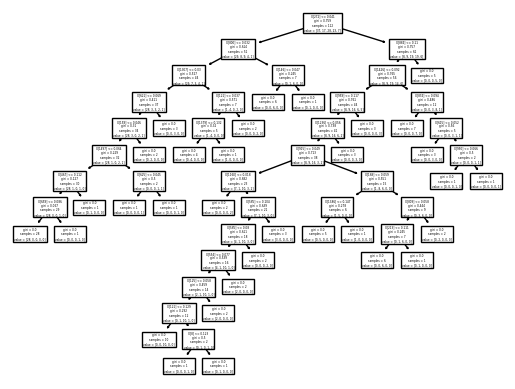

In [101]:
tree.plot_tree(dtc)

In [116]:
# evaluate the classifier on the test set
y_pred = dtc.predict(X_test)

In [117]:
y_pred

array([4, 1, 2, 1, 3, 4, 5, 2, 3, 3, 4, 1, 2, 2, 4, 2, 5, 4, 5, 3, 3, 2,
       3, 3, 5, 1, 1, 5], dtype=int64)

In [118]:
acc_decisiontree = accuracy_score(y_test, y_pred)
print("Accuracy:", acc_decisiontree)

Accuracy: 0.21428571428571427
